In [1]:
from lightglue_onnx import DISK, LightGlue, LightGlueEnd2End, SuperPoint, DISK
from lightglue_onnx.end2end import normalize_keypoints
from lightglue_onnx.utils import load_image, rgb_to_grayscale

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
torch.set_grad_enabled(False)

In [3]:
device = "cuda:0"
extractor = DISK(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="disk", depth_confidence=-1, width_confidence=-1).eval().to(device)  # create the matcher

Loaded LightGlue model


In [4]:
pipeline = LightGlueEnd2End(extractor, matcher).eval()

In [5]:
class SuperPointV2(nn.Module):
    def __init__(self, extractor):
        super().__init__()
        self.extractor = extractor
        self.max_num_keypoints = extractor.conf.max_num_keypoints

    def forward(self, image1):
        # RGB -> Grayscale
        image1 = TF.rgb_to_grayscale(image1)
        kpts0 = self.extractor(image1)[0]
        
        _, P, _ = kpts0.shape
        kpts0 = F.pad(kpts0, (0, 0, 0, self.max_num_keypoints - P), value=-1)
        
        return kpts0

In [6]:
class LighGlueEnd2EndV2(nn.Module):
    def __init__(self, pipeline, apply_rgb_to_grayscale=True):
        super().__init__()
        self.pipeline = pipeline
        self.max_num_keypoints = pipeline.extractor.conf.max_num_keypoints
        if apply_rgb_to_grayscale:
            self.preprocess_color = TF.rgb_to_grayscale
        else:
            self.preprocess_color = lambda x: x

    def forward(self, image1, image2):
        # RGB -> Grayscale
        image1 = self.preprocess_color(image1)
        image2 = self.preprocess_color(image2)
        kpts0, kpts1, matches, scores = self.pipeline(image1, image2)
        kpts0 = kpts0[0][matches[:, 0]]
        kpts1 = kpts1[0][matches[:, 1]]
        
        
        kpts0_pad = kpts0.new_full((self.max_num_keypoints, 2), fill_value=-1)
        kpts0_pad[:kpts0.shape[0]] = kpts0
        
        kpts1_pad = kpts1.new_full((self.max_num_keypoints, 2), fill_value=-1)
        kpts1_pad[:kpts1.shape[0]] = kpts1
        
        scores_pad = scores.new_full((self.max_num_keypoints,), fill_value=-1)
        scores_pad[:scores.shape[0]] = scores
        
        return kpts0_pad, kpts1_pad, scores_pad

In [7]:
from pathlib import Path
images = Path("assets")
img_size = (600, 800)

In [10]:
image0, _ = load_image(f"{images}/DSC_0411.JPG", resize=img_size)
image1, _ = load_image(f"{images}/DSC_0410.JPG", resize=img_size)
output = LighGlueEnd2EndV2(pipeline, apply_rgb_to_grayscale=False)(image0[None].cuda(), image1[None].cuda())

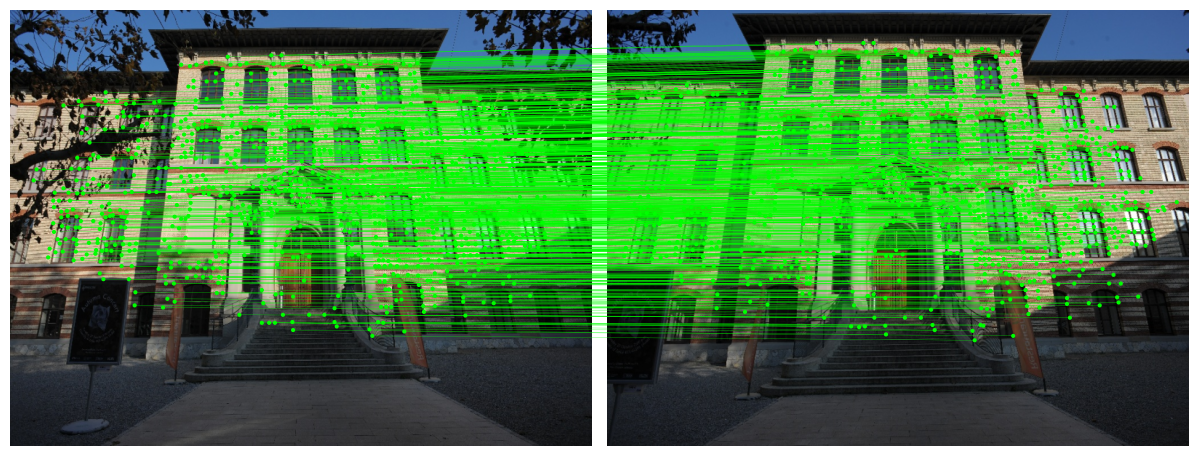

In [11]:
from lightglue import viz2d

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(output[0][output[2] != -1], output[1][output[2] != -1], color="lime", lw=0.2)

In [ ]:
torch.onnx.export(
    SuperPointV2(pipeline.extractor).eval(),
    (image0[None].cuda(),),
    "superpoint_v2.onnx",
    input_names=["image0"],
    output_names=[
        "kpts0",
    ],
    opset_version=17,
)

In [12]:
torch.onnx.export(
    LighGlueEnd2EndV2(pipeline, apply_rgb_to_grayscale=False).eval(),
    (image0[None].cuda(), image1[None].cuda()),
    "lightglue_disk.onnx",
    input_names=["image0", "image1"],
    output_names=[
        "kpts0",
        "kpts1",
        "mscores",
    ],
    opset_version=17,
)

/workspaces/LightGlue-ONNX/.venv/lib/python3.10/site-packages/kornia/feature/disk/_unets/unet.py:39: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if inp.size(1) != self.in_features:
/workspaces/LightGlue-ONNX/.venv/lib/python3.10/site-packages/kornia/feature/disk/_unets/unet.py:45: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if (inp.size(2) % input_size_divisor != 0) or (inp.size(3) % input_size_divisor != 0):
/workspaces/LightGlue-ONNX/.venv/lib/python3.10/site-packages/kornia/feature/disk/disk.py:57: TracerWarning: Converting a tensor to a Python 

In [ ]:
! trtexec --onnx=superpoint_v2.onnx --saveEngine=superpoint_v2.engine --explicitBatch --fp16

In [ ]:
! trtexec --onnx=lightglue_e2e_v2.onnx --saveEngine=lightglue_e2e_v2.engine --explicitBatch --fp16

In [13]:
! trtexec --onnx=lightglue_disk.onnx --saveEngine=lightglue_disk.engine --explicitBatch --fp16

72.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


&&&& RUNNING TensorRT.trtexec [TensorRT v8601] # trtexec --onnx=lightglue_disk.onnx --saveEngine=lightglue_disk.engine --explicitBatch --fp16
[05/15/2024-09:53:16] [W] --explicitBatch flag has been deprecated and has no effect!
[05/15/2024-09:53:16] [W] Explicit batch dim is automatically enabled if input model is ONNX or if dynamic shapes are provided when the engine is built.
[05/15/2024-09:53:16] [I] === Model Options ===
[05/15/2024-09:53:16] [I] Format: ONNX
[05/15/2024-09:53:16] [I] Model: lightglue_disk.onnx
[05/15/2024-09:53:16] [I] Output:
[05/15/2024-09:53:16] [I] === Build Options ===
[05/15/2024-09:53:16] [I] Max batch: explicit batch
[05/15/2024-09:53:16] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default
[05/15/2024-09:53:16] [I] minTiming: 1
[05/15/2024-09:53:16] [I] avgTiming: 8
[05/15/2024-09:53:16] [I] Precision: FP32+FP16
[05/15/2024-09:53:16] [I] LayerPrecisions: 
[05/15/2024-09:53:16] [I] Layer Device Types: 
[05/1